In [ ]:
# go to https://github.com/imagej/pyimagej/blob/master/doc/Install.md and follow instructions first!
#you need to install OpenJDK and maven before you can install imageJ.  
# --> maybe you also need to echo and adjust java system paths 
# use pip and brew! (I didn't add imageJ to env package list bc we don't know yet if it will be useful)

In [1]:
#The ImageJ gateway is initialized through a Java Virtual Machine (JVM). If you want to configure the JVM, it must be done before calling initializing an ImageJ gateway. E.g.:

# If all you want is the newest version of ImageJ2, with no custom configuration (e.g., extra memory allocated to Java), use this:

import imagej
import scyjava
scyjava.config.add_option('-Xmx6g')
#ij = imagej.init()

ij = imagej.init(['net.imagej:imageJ:2.0.0-rc-71', 'net.imagej:imagej-legacy', 'net.imagej:imagej-notebook:0.7.1'])


In [1]:
import imagej
ij = imagej.init('sc.fiji:fiji:2.1.1')
ij.getVersion()

'2.1.0/1.53c'

In [2]:
ij.getApp().getInfo(True)

'ImageJ 2.1.0/1.53c; Java 15.0.1 [x86_64]; 32MB of 2048MB'

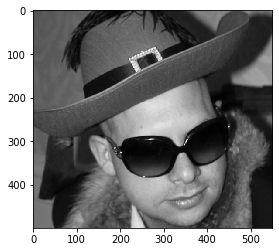

In [5]:
#ImageJ can display numpy images using ij.py.show. Let's demonstrate using scikit-image to grab a sample:

from skimage import io
import numpy as np
img = io.imread('/Users/nijeri/Documents/Malaria Project/Pictures/imageJ_tutorial/new-lenna.jpg')
img = np.mean(img[500:1000,300:850], axis=2)
ij.py.show(img, cmap = 'gray')

In [6]:
#The function to_java is capable of converting common Python and numpy data types into their Java/ImageJ equivalent. There is one important nuance; converting a numpy array to java creates a java object that points to the numpy array. This means that changing the java object also changes the numpy array.

#Let's take a look at lists:

# Lists convert and handle simply
ex_list = [1, 2, 3, 4]
print(type(ex_list))
java_list = ij.py.to_java(ex_list)
print(type(java_list))

<class 'list'>
<java class 'java.util.ArrayList'>


In [7]:
# A java list can be accessed the same as a python list. Changing values in the python list does not change values in the java_list

ex_list[0] = 4
java_list[0]

1

In [8]:
#By contrast, ops can operate on numpy arrays and change them, though you need to wrap the arrays in to_java first.

import numpy as np

arr1 = np.array([[1, 2], [3, 4]])
arr2 = np.array([[5, 6], [7, 8]])
arr_output = ij.py.new_numpy_image(arr1)

ij.op().run('multiply', ij.py.to_java(arr_output), ij.py.to_java(arr1), ij.py.to_java(arr2))
arr_output

array([[ 5, 12],
       [21, 32]])

In [9]:
#Numpy arrays become RandomAccessibleIntervals and can substitute for IterableIntervals.
print(type(ij.py.to_java(arr1)))

<java class 'net.imglib2.python.ReferenceGuardingRandomAccessibleInterval'>


In [10]:
#<java class 'net.imglib2.python.ReferenceGuardingRandomAccessibleInterval'>
#If you need to trouble shoot op workings, look for implementations that use only IterableIntervals or RandomAccessibleIntervals. To find the implementations use the print(ij.op().help()) function.

#For the multiply function the implementation we used is second to last (net.imagej.ops.math.IIToRAIOutputII$Multiply)

# print is required to render new lines
print(ij.op().help('multiply'))

Available operations:
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyDouble(
		ArrayImg arg,
		double value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyFloat(
		ArrayImg arg,
		float value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyLong(
		ArrayImg arg,
		long value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyShort(
		ArrayImg arg,
		short value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedLong(
		ArrayImg arg,
		long value)
	(Arr

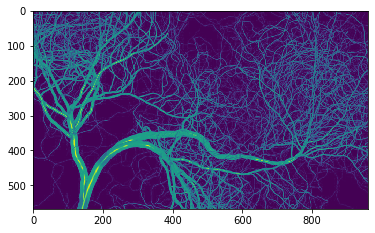

In [11]:
# to_java also works to convert into ImageJ types. Let's grab an image:

# Import an image with scikit-image.
# NB: Blood vessel image from: https://www.fi.edu/heart/blood-vessels
from skimage import io
url = '/Users/nijeri/Documents/Malaria Project/Pictures/imageJ_tutorial/General_EduRes_Heart_BloodVessels_0.jpg'
img = io.imread(url)
img = np.mean(img, axis=2)
ij.py.show(img)

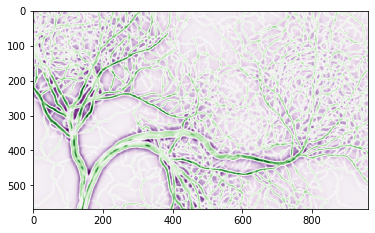

In [12]:
# Any Op that requires a RandomAccessibleInterval can run on a numpy array that has been passed to to_java. Remember that this method creates a view, meaning that the Op is modifying the underlying Python object:

#Let's run a Difference of Gaussians on our numpy image using ImageJ:


result = np.zeros(img.shape)
# these sigmas will be nice for the larger sections
sigma1 = 8
sigma2 = 2
# note the use of to_java on img and result to turn the numpy images into RAIs
ij.op().filter().dog(ij.py.to_java(result), ij.py.to_java(img), sigma1, sigma2)
# purple highlights the edges of the vessels, green highlights the centers
ij.py.show(result, cmap = 'PRGn')

[java.lang.Enum.toString] 18:14:31.825 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - processor is INTEL_64 os.arch is x86_64
[java.lang.Enum.toString] 18:14:31.828 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is OSX_64 os.name is mac os x
[java.lang.Enum.toString] 18:14:31.829 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is OSX_64 os.name is mac os x
[java.lang.Enum.toString] 18:14:31.835 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - platform specific path is natives/osx_64/
[java.lang.Enum.toString] 18:14:31.836 [main] DEBUG org.scijava.nativelib.BaseJniExtractor - mappedLib is libturbojpeg.dylib
[java.lang.Enum.toString] 18:14:31.839 [main] DEBUG org.scijava.nativelib.BaseJniExtractor - Couldn't find resource natives/osx_64/libturbojpeg.dylib
[java.lang.Enum.toString] 18:14:31.840 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - platform specific path is osx_64/
[java.lang.Enum.toString] 18:14:31.841 [main] DEBUG o

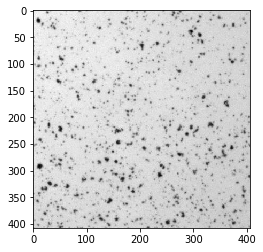

In [13]:
# from_java works in reverse of to_java and can be used to further process ImageJ data types with numpy, scikit-image, etc.

# Open an image from the url using the IJ scripting interface and then send it to a numpy array.


url_colony = '/Users/nijeri/Documents/Malaria Project/Pictures/imageJ_tutorial/Cell_Colony.jpg'

# Load the image
cell_colony = ij.io().open(url_colony)

# Send it to numpy
numpy_colony = ij.py.from_java(cell_colony)

# Display the image
ij.py.show(numpy_colony, cmap='gray')